# Load injection - Homemade python script

This notebook studies the impact of different load injection on the response time of CoAP requests

In [1]:
import os
cur_dir=os.getcwd() # save current directory to save the generated CSV files

%cd ../../..
%pwd

/home/jovyan/work


'/home/jovyan/work'

## Introduction

This notebook uses the 03-g5k-iotlab.ipynb to evaluate the impact on the response time of different load injections. For that, we vary the **sleep_interval**, keeping the other parameters fixed.

It is divided in 3 main parts, which could be 3 different notebooks depending on the complexity of your study. For the hackathon, however, we opt for keeping them in the same notebook.

- **Description**: creates a data frame containing the description of the different parameters of your experiment. In our case the different **sleep_interval** used.
- **Running**: Reads the data frame with the description the experiment and runs each experiment. It uses papermill to call the 03-g5k-iotlab.ipynb notebook with the correct parameters. Also, creates a data frame with the results.
- **Analysis**: Finally, read the output from the running phase and performs the data analysis.

Note that you can run each part **independently**. It only depends on running the first cell of this notebook to set the cur_dir properly.

## Description

Describing the parameters used in the different experiment runs.

In [2]:
import pandas
import io
import uuid
import datetime

# Probably a programmatic way to describe the test is better...
experiments=io.StringIO("""
firmware,iotlab_nodes,g5k_nodes,duration,sleep_interval
contikimac,4,1,300,0.05
contikimac,4,1,300,0.1
contikimac,4,1,300,0.2
contikimac,4,1,300,1
""")

job_name="rsd-hackathon"

df = pandas.read_csv(experiments)

df['exp_id'] = [str(uuid.uuid4()) for _,_ in df.iterrows()]
df['date'] = str(datetime.date.today())
df['data_dir'] = ["data/raw/%s/%s" % (i['date'], i['exp_id']) for _,i in df.iterrows()]
df['notebook_dir'] = ["%s/%s" % (cur_dir, i['exp_id']) for _,i in df.iterrows()]
df['state'] = 'created'

df = df.sample(frac=1).reset_index(drop=True) # randomize test execution
df.to_csv("%s/experiment.csv" % cur_dir)
df

firmware  iotlab_nodes  g5k_nodes  duration  sleep_interval  \
0  contikimac             4          1       300            0.20   
1  contikimac             4          1       300            1.00   
2  contikimac             4          1       300            0.10   
3  contikimac             4          1       300            0.05   

                                 exp_id        date  \
0  c76b9bff-64c2-497b-b388-c5cbaf41744f  2021-09-07   
1  0679235d-28b2-458d-bb13-f6dfeae5f138  2021-09-07   
2  2734a140-7672-4c8e-b1b0-c1f94ca0b7b1  2021-09-07   
3  6e4469da-9fbf-4a5b-9dfb-1fc81eb905dd  2021-09-07   

                                            data_dir  \
0  data/raw/2021-09-07/c76b9bff-64c2-497b-b388-c5...   
1  data/raw/2021-09-07/0679235d-28b2-458d-bb13-f6...   
2  data/raw/2021-09-07/2734a140-7672-4c8e-b1b0-c1...   
3  data/raw/2021-09-07/6e4469da-9fbf-4a5b-9dfb-1f...   

                                        notebook_dir    state  
0  /home/jovyan/analysis/04-load-injection/2021-0...  created  
1  /home/jovyan/analysis/04-load-injection/2021-0...  created  
2  /home/jovyan/analysis/04-load-injection/2021-0...  created  
3  /home/jovyan/analysis/04-load-injection/2021-0...  created

## Running

In [3]:
import papermill as pm
import pathlib
import pandas

# read the description of the experiment
df = pandas.read_csv("%s/experiment.csv" % cur_dir)
for index, exp in df.iterrows():
    if exp['state'] != 'created':
        continue

    print("Running experiment number: %d, ID: %s, firmware: %s, sleep_interval %f" % (index, exp['exp_id'], exp['firmware'], exp['sleep_interval']))
    pathlib.Path(exp['notebook_dir']).mkdir(exist_ok=True, parents=True)
    
    # run notebook
    pm.execute_notebook(
        'analysis/03-grid5000/03-g5k-iotlab.ipynb',
        '%s/04-load-injection-%f-%s.ipynb' % (exp['notebook_dir'], exp['sleep_interval'], exp['exp_id']),
        cwd = "analysis/03-grid5000/",  # going to folder to execute notebook
        parameters = dict(
            output_dir = exp['data_dir'],
            er_image = "data/firmware/%s/er-example-server.iotlab-m3" % exp['firmware'],
            br_image = "data/firmware/%s/border-router.iotlab-m3" % exp['firmware'],
            free_resources = False if index < len(df.index) - 1 else True, #free resources in last experiment
            duration = exp['duration'],
            sleep_interval = exp['sleep_interval'],
            iotlab_nodes = exp['iotlab_nodes'],
            iotlab_site = 'grenoble',
            g5k_nodes = exp['g5k_nodes'],
        )
    )
    # change and save new state
    df.at[index, 'state'] = 'executed'
    df.to_csv("%s/experiment.csv" % cur_dir)


Running experiment number: 0, ID: c76b9bff-64c2-497b-b388-c5cbaf41744f, firmware: contikimac, sleep_interval 0.200000


Executing:   0%|          | 0/68 [00:00<?, ?cell/s]

Running experiment number: 1, ID: 0679235d-28b2-458d-bb13-f6dfeae5f138, firmware: contikimac, sleep_interval 1.000000


Executing:   0%|          | 0/68 [00:00<?, ?cell/s]

Running experiment number: 2, ID: 2734a140-7672-4c8e-b1b0-c1f94ca0b7b1, firmware: contikimac, sleep_interval 0.100000


Executing:   0%|          | 0/68 [00:00<?, ?cell/s]

Running experiment number: 3, ID: 6e4469da-9fbf-4a5b-9dfb-1fc81eb905dd, firmware: contikimac, sleep_interval 0.050000


Executing:   0%|          | 0/68 [00:00<?, ?cell/s]

Parse and salve results.

In [4]:
import pandas
import os.path

# where to save the results from experiment, open file if it already exists
results_filename = "%s/results.csv" % cur_dir
out = None

# read the description of the experiment
df = pandas.read_csv("%s/experiment.csv" % cur_dir)
for index, exp in df.iterrows():
    if exp['state'] != 'executed':
        continue

    # read and save output of this test
    temp = pandas.read_csv(exp['data_dir'] + "/elapsed_time.csv")
    temp['exp_id'] = exp['exp_id']
    temp['sleep_interval'] = exp['sleep_interval']
    out = pandas.concat([out, temp])
    out.to_csv(results_filename)

## Analysis

Read the dataframe with the results of all experiments.

In [2]:
%load_ext rpy2.ipython
import pandas

out = pandas.read_csv("%s/results.csv" % cur_dir)

# remove invalid entries
out = out[out['n'].notna()]
out = out[out['elapsed'].notna()]
print(out[out.isna().any(axis=1)])
out

Empty DataFrame
Columns: [Unnamed: 0, timestamp, n, node, ok, elapsed, exp_id, sleep_interval]
Index: []


Unnamed: 0     timestamp     n                      node  ok   elapsed  \
0               0  1.631007e+09     0  2001:660:5307:3130::a269   1  0.282764   
1               1  1.631007e+09     1  2001:660:5307:3130::a269   1  0.157978   
2               2  1.631007e+09     2  2001:660:5307:3130::a269   1  0.241345   
3               3  1.631007e+09     3  2001:660:5307:3130::a269   1  0.168436   
4               4  1.631007e+09     4  2001:660:5307:3130::a269   1  0.087901   
...           ...           ...   ...                       ...  ..       ...   
10096        3656  1.631009e+09  1274  2001:660:5307:3130::b679   1  0.085668   
10097        3657  1.631009e+09  1275  2001:660:5307:3130::b679   1  0.104839   
10098        3658  1.631009e+09  1276  2001:660:5307:3130::b679   1  0.218728   
10099        3659  1.631009e+09  1277  2001:660:5307:3130::b679   1  0.239641   
10100        3660  1.631009e+09  1278  2001:660:5307:3130::b679   1  0.102318   

                                     exp_id  sleep_interval  
0      c76b9bff-64c2-497b-b388-c5cbaf41744f            0.20  
1      c76b9bff-64c2-497b-b388-c5cbaf41744f            0.20  
2      c76b9bff-64c2-497b-b388-c5cbaf41744f            0.20  
3      c76b9bff-64c2-497b-b388-c5cbaf41744f            0.20  
4      c76b9bff-64c2-497b-b388-c5cbaf41744f            0.20  
...                                     ...             ...  
10096  6e4469da-9fbf-4a5b-9dfb-1fc81eb905dd            0.05  
10097  6e4469da-9fbf-4a5b-9dfb-1fc81eb905dd            0.05  
10098  6e4469da-9fbf-4a5b-9dfb-1fc81eb905dd            0.05  
10099  6e4469da-9fbf-4a5b-9dfb-1fc81eb905dd            0.05  
10100  6e4469da-9fbf-4a5b-9dfb-1fc81eb905dd            0.05  

[10101 rows x 8 columns]

### Number of OK requests

In [3]:
%%R -i out
library(dplyr)

out %>% group_by(node) %>% filter(ok == 1) %>% count()

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# A tibble: 3 x 2
# Groups:   node [3]
  node                         n
  <chr>                    <int>
1 2001:660:5307:3130::a172  3361
2 2001:660:5307:3130::a269  3287
3 2001:660:5307:3130::b679  3453


### Number of NOK requests

In [4]:
%%R -i out

out %>% group_by(node) %>% filter(ok != 1) %>% count()

# A tibble: 0 x 2
# Groups:   node [0]
# … with 2 variables: node <chr>, n <int>


### 'Mean elapsed time' against 'Sleep Interval' , simple plot

Average of elapsed time considering all sensors.

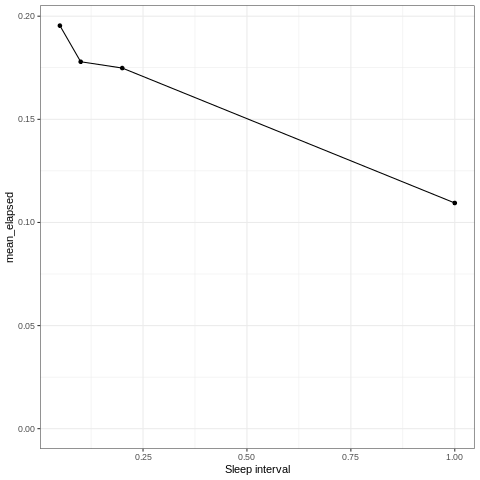

In [5]:
%%R -i out
library(ggplot2)

out %>% group_by(sleep_interval) %>% summarize(mean_elapsed = mean(elapsed)) %>%
ggplot(aes(x=sleep_interval, y=mean_elapsed)) + geom_point() + geom_line() +
    xlab("Sleep interval") + ylim(0, NA) + theme_bw()

### Response time ($R$) against $\lambda$ (theoretical) 

See response time (or elapsed time) versus theoretical $\lambda$ (1/sleep interval).

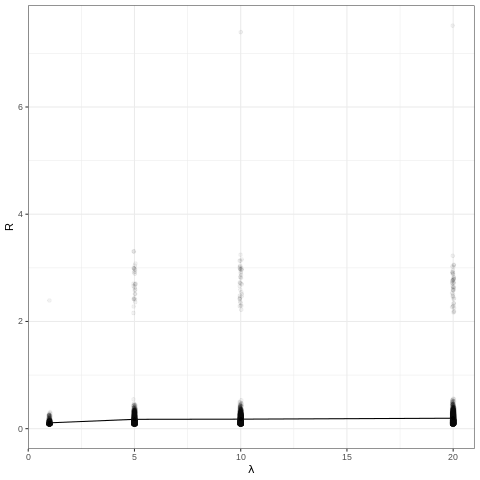

In [6]:
%%R -i out

out %>% group_by(sleep_interval) %>% summarize(mean_elapsed = mean(elapsed)) %>%
ggplot(aes(1/sleep_interval, mean_elapsed)) + geom_point() + geom_line() +
    geom_jitter(data=out, aes(1/sleep_interval, elapsed), alpha=.05, width=.05) + 
    ylab(expression("R")) + ylim(0, NA) + xlab(expression(lambda)) + theme_bw()

We can notice that some messages take much longer than others.

Are they from a single node or did they occur in a precise timestamp? Let's verify.

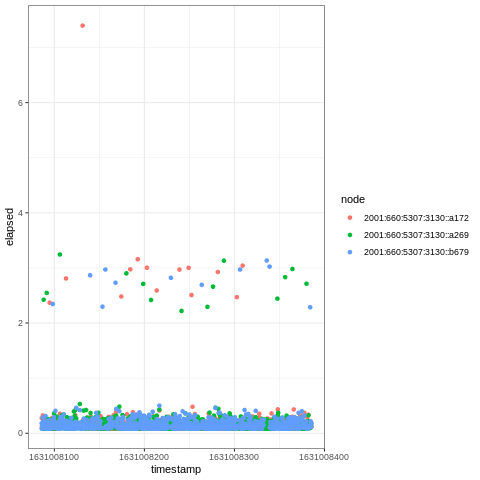

In [7]:
%%R -i out
library(ggplot2)
library(dplyr)
out %>% filter(sleep_interval==.1) %>% ggplot(aes(timestamp, elapsed,color=node)) + geom_point(alpha=1) + theme_bw()

### Response time ($R$) against $\lambda$ (theoretical) (per sensor)

See response time (or elapsed time) versus theoretical $\lambda$ (1/sleep interval).
One plot per sensor.

`summarise()` has grouped output by 'node'. You can override using the `.groups` argument.


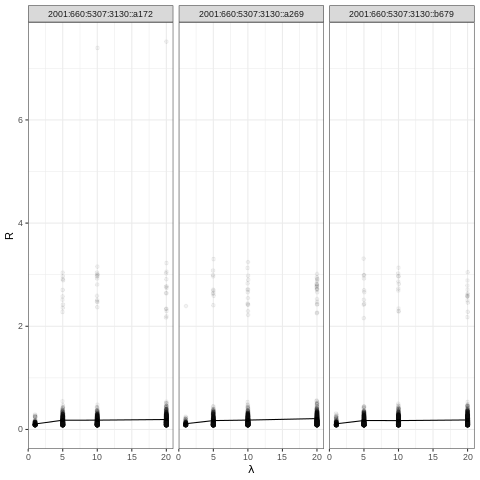

In [8]:
%%R -i out

out %>% group_by(node, sleep_interval) %>% summarize(mean_elapsed = mean(elapsed)) %>%
ggplot(aes(1/sleep_interval, mean_elapsed)) + geom_point() + geom_line() +
    geom_jitter(data=out, aes(1/sleep_interval, elapsed), alpha=.05, width=.05) + 
    ylab(expression("R")) + xlab(expression(lambda)) +
    facet_wrap(~node) + ylim(0, NA) + theme_bw()

### Response time ($R$) against $\lambda$ (observed)

Observed $\lambda$: count number of requests done and divide by experiment duration (300s).

`summarise()` has grouped output by 'sleep_interval'. You can override using the `.groups` argument.


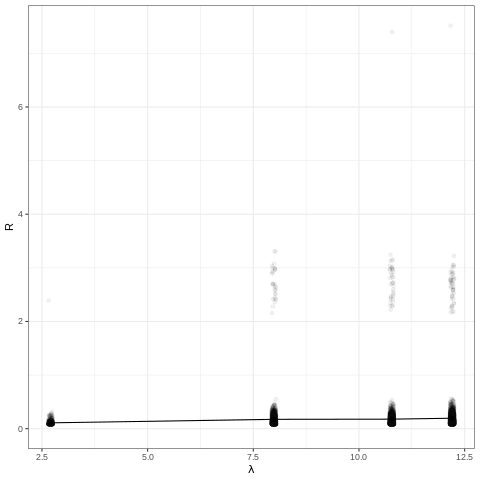

In [9]:
%%R -i out

out = out %>% group_by(sleep_interval) %>% mutate(lambda=n()/300)
head(out)
out %>% group_by(sleep_interval) %>% summarize(lambda=lambda,
                                               mean_elapsed = mean(elapsed)) %>%
ggplot(aes(lambda, mean_elapsed)) + geom_point() + geom_line() +
    geom_jitter(data=out, aes(lambda, elapsed), alpha=.05, width=.05) + 
    ylab(expression("R")) + ylim(0, NA) + xlab(expression(lambda)) + theme_bw()

Zooming in range 0, 0.5.

In [10]:
%%R -i out

out = out %>% group_by(sleep_interval) %>% mutate(lambda=n()/300)
out %>% group_by(sleep_interval) %>% summarize(lambda=lambda,
                                               mean_elapsed = mean(elapsed)) %>%
ggplot(aes(lambda, mean_elapsed)) + geom_point() + geom_line() +
    geom_jitter(data=out, aes(lambda, elapsed), alpha=.05, width=.05) + 
    ylab(expression("R")) + xlab(expression(lambda)) + ylim(0, .5) + theme_bw()

`summarise()` has grouped output by 'sleep_interval'. You can override using the `.groups` argument.


### $1/R$ against $\lambda$ (observed)

In [11]:
%%R -i out

out %>% group_by(sleep_interval) %>% summarize(lambda=mean(n()/300),
                                               mean_elapsed = mean(elapsed)) %>%
ggplot(aes(lambda, 1/mean_elapsed)) + geom_point() + geom_line() +
    ylab(expression("1/R")) + ylim(0, NA) + xlab(expression(lambda)) + theme_bw()